# hidden Markov Model tuned to mouse behavior

Here the idea is that the the hmm knows more than the mouse - it knows exactly the reward probabilities as well as the transition probabilities. 

So what if the mouse is acting like a hmm, but with different parameters?

Here, I feed the HMM actual behavioral data from several sessions. For each trial, the HMM calculates its posterior beliefs about the state of 'z'. Then the belief is compared to the actual decision of the mouse. 

For example, say the HMM calculates p(z==0) = 0.25 and p(z==1) = 0.75, and the mouse chose port 1. The likelihood of the behavioral data under the model is 0.75 (or 0.25 if the mouse chose port 0). 

In this way, I calculate the negative log likelihood of the data under the model, and tune the reward probability 'p' and the transition probability 'd'to minimize the negative log likelihood.

Followed example for calculating forward probability from the [Forward-Backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm) wiki page

More notes on updating forward probability

$ \text{Let} \ \ b_{t+1} = p(z_{t+1} | r_{1:t}, a_{1:t}) $

Then

$ b_{t+1} = \sum_k p(z_{t+1} | z_t=k)  * p(z_t=k | r_{1:t}, a_{1:t})  \propto \sum_k p(z_{t+1} | z_t=k)  * p(r_t | z_t = k, a_t) * p(z_t=k | r_{1:t-1}, a_{1:t-1}) $

$ b_{t+1} = \sum_k p(z_{t+1} | z_t=k)  * p(r_t | z_t = k, a_t) * b_{t,k} $

In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import numpy as np
import numpy.random as npr
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import bandit_preprocessing as bp
%matplotlib inline

# Load in mouse data

In [10]:
data_mouse = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_7030_02192017.csv',index_col=0)
data_hmm_nottuned = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_full_7030_greedy.csv',index_col=0)
data_mouse.shape

(17856, 50)

# use tuned parametes, run hmm, compare to test data

In [37]:
# tuned parameters
duration = 70
p = 0.75 # prob of reward if choose the correct side
q = 1.0-p # prob of reward if choose the incorrect side
epsilon = 0.05

# setting up the game
n_plays = 10000

#true latent state sequence
state = (np.arange(n_plays)) // duration % 2 #this just returns [0,0,....,1,1,...] etc 
#for each state so we can keep track. 

#transition matrix
'''
set transition matrix T such that T[i,j] is the probability of transitioning
from state i to state j. 
If the true number of trials before switching is 'duration', then set the
probability of switching to be 1 / duration, and the probability of 
staying to 1 - 1 / duration
'''
s = 1 - 1./duration
T = np.array([[s, 1.0-s],
             [1.0-s,s]])


#observation array
'''
set up array such that O[r,z,a] = Pr(reward=r | state=z,action=a)

eg. when action = L, observation matrix should be:
O[:,:,1]    = [P(r=0 | z=0,a=0),  P(r=0 | z=1,a=0)
               P(r=1 | z=0,a=0),  P(r=1 | z=1,a=0)]
            = [1-p, 1-q
                p,   q]
'''
O = np.zeros((2,2,2))
# let a 'right' choice be represented by '0'
O[:,:,0] = np.array([[1.0-p, 1.0-q],
                     [p,q]])
O[:,:,1] = np.array([[1.0-q, 1.0-p],
                     [q,p]])

#TEST: All conditional probability distributions must sum to one
assert np.allclose(O.sum(0),1), "All conditional probability distributions must sum to one!"

#Initialize an array for actions (a[i] = 0 --> right, a[i] = 1 --> left)
actions = np.zeros(n_plays)

#Initialize an array for rewards (outcomes) (1 = reward, 0 = no reward)
rewards = np.zeros(n_plays)

#Keep track of beliefs over which side will be rewarded
#First column is left, second is right
beliefs = np.nan*np.ones((n_plays+1,2)) # +1 since the belief is always about the next trial

#initialize with both sides equally likely
beliefs[0] = [0.5,0.5]

trials = np.zeros((n_plays,4))

#run the algorithm
for play in range(n_plays):
    assert np.allclose(beliefs[play].sum(), 1.0), "Beliefs must sum to one!"
    
    #choose an action
    '''
    different strategies could be employed here.
    eg 'greedy' <-- where action[play] = np.argmax(beliefs[play]). However
    this is actually suboptimal because it doesn't do any exploration. 
    
    in Thompson sampling, instead want to sample from your belief probabilities:
    ie actions[play] ~ beliefs[play]
    '''
    #actions[play] = npr.choice(2,p=beliefs[play])
    #actions[play] = np.where(beliefs[play] == beliefs[play].max())[0][0]
    
    '''
    EPSILON-GREEDY
    '''
    if np.random.uniform(size=1) > epsilon:
        actions[play] = np.where(beliefs[play] == beliefs[play].max())[0][0]
    else:
        actions[play] = np.where(beliefs[play] == beliefs[play].min())[0][0]
        
    #recieve reward based on the action
    p_reward = O[:,state[play],actions[play]]
    rewards[play] = npr.choice(2,p=p_reward) #bc of the way we set up the outcomes matrix, the first prob corresponds
    #to not getting a reward, so we get a 0 for no reward and a 1 for a reward :)
    
    
    '''
    update trial matrix
    1. time
    2. port (1=right,2=left)
    3. right port reward porb
    4. left port reward prob
    5. reward given 1/0
    
    obviously we won't encode a time.
    '''
    # action (port)
    trials[play,0] = actions[play] #the 2s need to become zeros after
    
    
    if state[play] == 1: #we are in a 'left' state
        trials[play,[1,2]] = [q,p]
    else: # we are in a 'right' state
        trials[play,[1,2]] = [p,q]
    
    # outcome (reward given y/n)
    trials[play,3] = rewards[play]
    
    
    #update beliefs
    
    #step 1: multiply by p(r_t | z_t = k, a_t)
    belief_temp = O[rewards[play],:,actions[play]] * beliefs[play]
    
    #step 2: sum over z_t, weighting by transition matrix
    beliefs[play+1] = T.dot(belief_temp)
    
    #step 3: normalize
    beliefs[play+1] /= beliefs[play+1].sum()

#switch ports
trials[:,0] = trials[:,0] + 1

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:118: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Convert hmm & mouse data into feature matrices

In [38]:
#HMM
col_names = ['Port Poked','Right Reward Prob','Left Reward Prob','Reward Given']
trial_df_hmm = pd.DataFrame(data=trials,index=None,columns=col_names)
trial_df_hmm['Since last trial (s)'] = 0
trial_df_hmm['Trial Duration (s)'] = 0

data_hmm_tuned = bp.create_reduced_feature_matrix(trial_df_hmm,'hmm_7030','thesis')

In [9]:
#load in 80_20 data
data_hmm_nottuned = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_full_7030_greedy.csv',index_col=0)
#data_hmm_nottuned = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/hmm_matrix_8020.csv',index_col=0)

In [26]:
datas = [data_mouse,data_hmm_tuned,data_hmm_nottuned]

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an intege

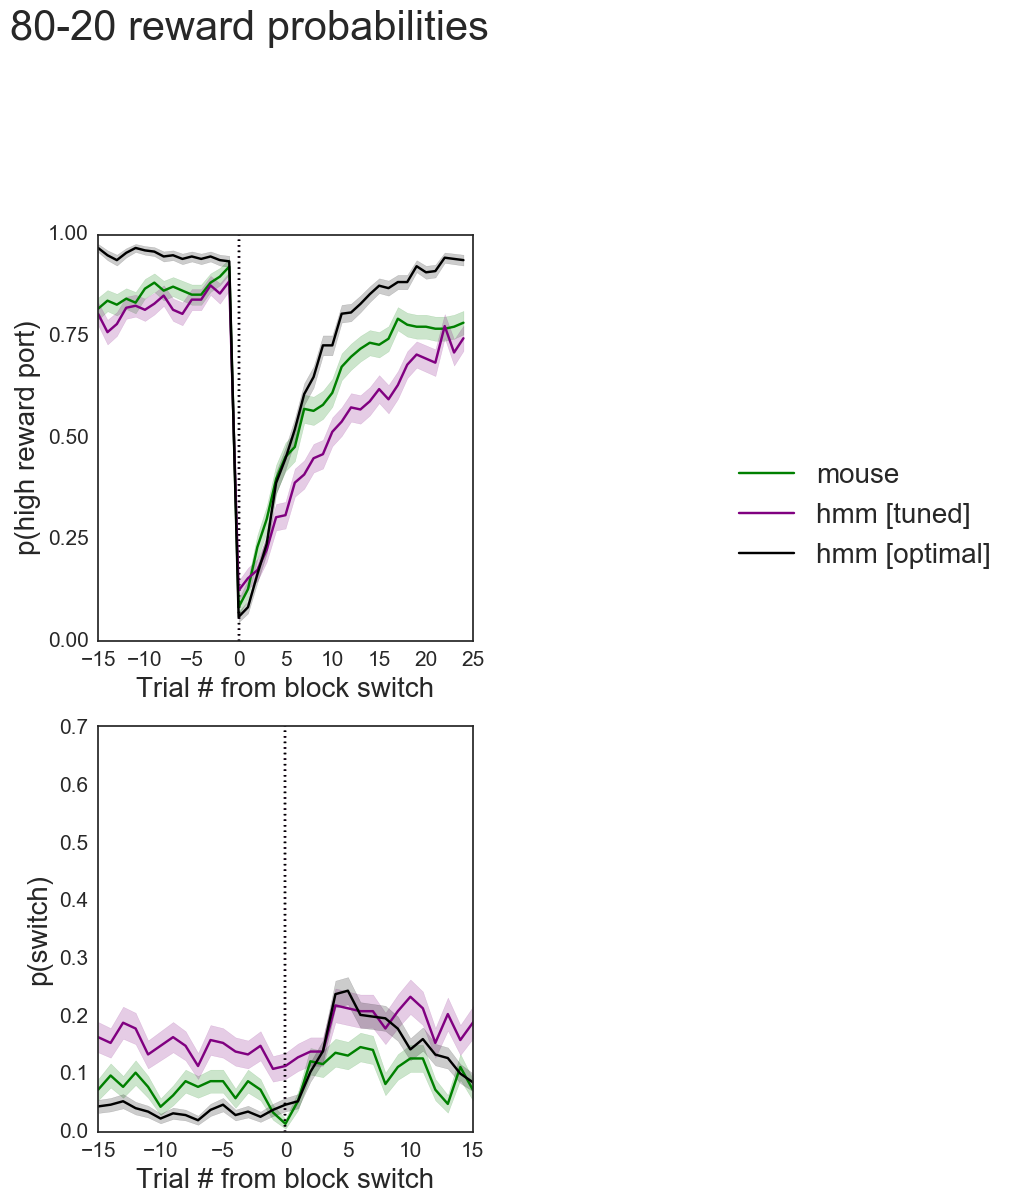

In [39]:
sns.set_style('white')
plt.figure(figsize=(5,10))
plt.suptitle('80-20 reward probabilities',x=0.5,y=1.2,fontsize=30)

labels = ['mouse','hmm [tuned]','hmm [optimal]']
colors = ['green','purple','black']

for c,data in enumerate(datas):

    switches = data['Switch'].values

    t_block_unique = np.unique(data['Block Trial'].values)
    p_switch_block = np.zeros((t_block_unique.shape[0],2))
    high_p_port = np.zeros_like(p_switch_block)
    trial_block_count = np.zeros_like(t_block_unique)

    for t in t_block_unique:
        p_switch_block[t,0] = data[data['Block Trial'] == t]['Switch'].mean(axis=0)
        trial_block_count[t] = data[data['Block Trial'] == t].shape[0]
        p_switch_block[t,1] = data[data['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[t])

        high_p_port[t,0] = data[data['Block Trial']==t]['Higher p port'].mean(axis=0)
        high_p_port[t,1] = data[data['Block Trial']==t]['Higher p port'].std(axis=0) / np.sqrt(trial_block_count[t])


    data.index = np.arange(data.shape[0]) # <-- this is important
    switch_points = data[data['Block Trial'] == 0].index.values

    L = 15
    paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
    paraswitch_port = np.zeros_like(paraswitch)

    for i,point in enumerate(switch_points):
        try:
            paraswitch[i,:] = data.iloc[point-L:point+L+10]['Switch']
            paraswitch_port[i,:] = data.iloc[point-L:point+L+10]['Higher p port']
        except:
            pass

    u = paraswitch.mean(axis=0)
    s = paraswitch.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])

    #plt.figure(figsize=(15,5))
    #plt.suptitle('analysis of blocks where probabilities switched every 50 rewards',x=0.5,y=1.1,fontsize=20)

    plt.subplot(212)
    plt.plot(np.arange(-1*L,L+10),u,color=colors[c])
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color=colors[c],alpha=0.2)
    plt.vlines(x=0,ymin=0,ymax=1.0,color=colors[c],linestyle='dotted')
    plt.xlabel('Trial # from block switch',fontsize=20)
    plt.ylabel('p(switch)',fontsize=20)
    #plt.title('p(switch) around the block switch',fontsize=20,x=0.5,y=1.1)
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(-1*L,L)
    plt.ylim(0,0.705)

    plt.subplot(211)
    u = paraswitch_port.mean(axis=0)
    s = paraswitch_port.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])
    plt.plot(np.arange(-1*L,L+10),u,color=colors[c],label=labels[c])
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color=colors[c],alpha=0.2)
    plt.vlines(x=0,ymin=0,ymax=1,color=colors[c],linestyle='dotted')
    plt.xlabel('Trial # from block switch',fontsize=20)
    plt.ylabel('p(high reward port)',fontsize=20)
    #plt.title('probability of choosing high reward port \naround the block switch',fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L+10)
    plt.xticks(fontsize=15)
    plt.yticks([0,0.25,0.5,0.75,1],fontsize=15)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(2.45,0.5),fontsize=20)

    plt.tight_layout()

['hmm-opt' 'hmm-tuned' 'mouse']


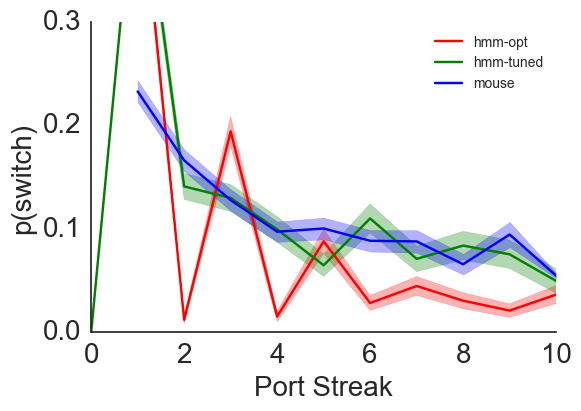

In [22]:
data_mouse['Condition'] = 'mouse'
data_hmm_tuned['Condition'] = 'hmm-tuned'
data_hmm_nottuned['Condition'] = 'hmm-opt'

datas =  data_mouse.append(data_hmm_tuned)
datas = datas.append(data_hmm_nottuned)


conditions = np.unique(datas['Condition'].values)
print(conditions)
colors = ['red','green','blue']

fontsize=20
for j,condition in enumerate(conditions):
    data = datas[datas['Condition'] == condition].copy()
    port_streaks = np.unique(data['Port Streak'].values)
    p_switch = np.zeros((port_streaks.shape[0],2))

    for i,streak in enumerate(port_streaks):
            switches = data[data['Port Streak'] == streak]['Switch']
            p_switch[i,0] = switches.mean()
            p_switch[i,1] = switches.std() / np.sqrt(switches.shape[0])

    plt.plot(port_streaks,p_switch[:,0],color=colors[j],label=condition)
    plt.fill_between(x=port_streaks,y1=p_switch[:,0]+p_switch[:,1],y2=p_switch[:,0]-p_switch[:,1],color=colors[j],alpha=0.3)
    plt.xlabel('Port Streak',fontsize=fontsize)
    plt.ylabel('p(switch)',fontsize=fontsize)
    plt.xticks(fontsize=20)
    plt.yticks([0,0.1,0.2,0.3],fontsize=fontsize)

plt.legend(loc='best')
plt.xlim(0,10)
plt.ylim(0,0.3)
sns.despine()

['hmm-opt' 'hmm-tuned' 'mouse']


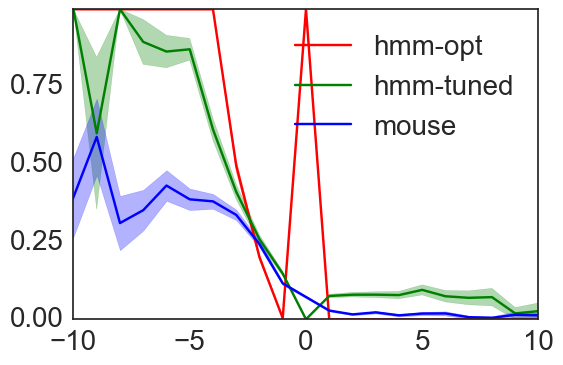

In [23]:
conditions = np.unique(datas['Condition'].values)
print(conditions)
colors = ['red','green','blue']

for j,condition in enumerate(conditions):
    data = datas[datas['Condition'] == condition].copy()
    reward_streaks = np.unique(data['Reward Streak'].values)
    p_switch = np.zeros((reward_streaks.shape[0],2))

    for i,streak in enumerate(reward_streaks):
            switches = data[data['Reward Streak'] == streak]['Switch']
            p_switch[i,0] = switches.mean()
            p_switch[i,1] = switches.std() / np.sqrt(switches.shape[0])

    plt.plot(reward_streaks,p_switch[:,0],color=colors[j],label=condition)
    plt.fill_between(x=reward_streaks,y1=p_switch[:,0]+p_switch[:,1],y2=p_switch[:,0]-p_switch[:,1],color=colors[j],alpha=0.3)
    #plt.xlabel('Reward Streak',fontsize=fontsize)
    #plt.ylabel('p(switch)',fontsize=fontsize)
    plt.yticks([0,0.25,0.5,0.75],fontsize=fontsize)
    plt.xticks(fontsize=20)
    plt.xlim(-10,10)
    plt.legend(loc='best',fontsize=fontsize)
    #plt.yticks([0,0.1,0.2,0.3],fontsize=20)

